In [ ]:
""" 
File to import and implement ARIMA models and different types of smoothing and lagging
"""

In [ ]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import MAE
from sklearn.metrics import mean_absolute_error

In [ ]:
# Load data
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

df_prod_2_year_cons = pd.read_csv('data/year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('data/year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [ ]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [ ]:
# Define a baseline function
def baseline_model(series, units_to_forecast, unit = "hours"):
    """Create baseline from series

    Args:
        series (pd.Series): series to create baseline from
        days_to_forecast (int): days to forecast

    Returns:
        pd.Series: Baseline forecast
    """

    if unit == "days":
        factor = 1
    if unit == "hours":
        factor = 24

    # For each day to forecast, get the value from the last week
    # Create series with index same as series
    baseline = pd.Series(index=series.index[-units_to_forecast+1:])
    # For each day to forecast
    for i in range(units_to_forecast-1):
        # Get the last week
        last_week = series.iloc[i-7*2*factor]
        # Add to baseline
        baseline[i] = last_week

    
    # Return forecast
    # invert the list
    return baseline

In [18]:
# Cut data to only use the first year
series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="prod",
                        start=None,
                        end=None,
                        agg="day")
print(series.head(10))

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh_normalized
timeslot                                     
2016-09-04 00:00:00+00:00            0.000000
2016-09-05 00:00:00+00:00            0.638889
2016-09-06 00:00:00+00:00            0.083333
2016-09-07 00:00:00+00:00            0.500000
2016-09-08 00:00:00+00:00            0.361111
2016-09-09 00:00:00+00:00            0.000000
2016-09-10 00:00:00+00:00            0.000000
2016-09-11 00:00:00+00:00            0.027778
2016-09-12 00:00:00+00:00            0.416667
2016-09-13 00:00:00+00:00            0.277778


In [ ]:
# We can also just cheat and use pmdarima to get the best difference term
from pmdarima.arima import ndiffs, nsdiffs 

print(ndiffs(series))
print(nsdiffs(series, m=4*30))

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    print("Converting data to cool stuff")
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        print("dropping NaNs")
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    print("Splitting data set")
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=2)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        print("Fitting to RF-model ",i)
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        #history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

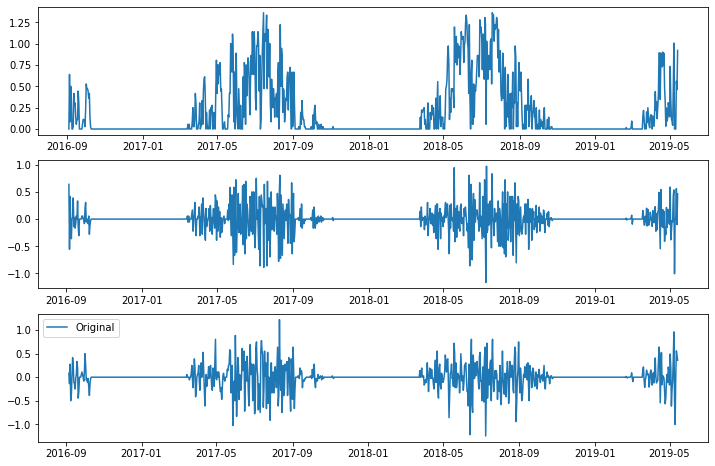

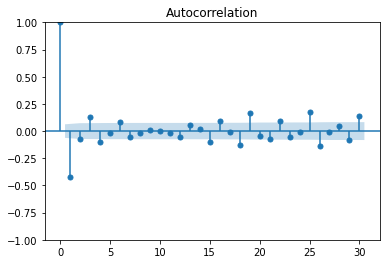

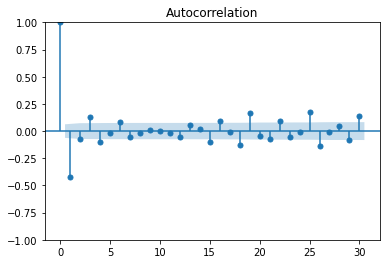

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import make_subplots

series_1_diff = series.diff().dropna()
series_2_diff = series.diff(2).dropna()

# make matplotlib subplots for plotting series_1_diff and series_2_diff
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
ax1.plot(series)
ax2.plot(series_1_diff)
ax3.plot(series_2_diff)
plt.legend(['Original', '1st Diff', '2nd Diff'])

plt.show()

plot_acf(series_1_diff)

We see that the series is stationary when doing a single difference

In [ ]:
# Fit model

# ARIMA MODEL EXPLAINED
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

train_series = series_1_diff

units_to_forecast = 4

AR = 1
I = 0
MA = 1

P = 1
D = 0
Q = 1
M = 4*30

# SARIMA
ARIMA_order = (AR, I, MA)
SEASONAL_order = (P, D, Q, M)

sarima_model = SARIMAX(train_series[:-units_to_forecast], order=ARIMA_order, seasonal_order=SEASONAL_order)
sarima_model_fit = sarima_model.fit()
sarima_forecast = sarima_model_fit.forecast(steps=units_to_forecast)

# RANDOM FOREST
df_mm_prod = df_prod[df_prod["meter_id"] == "28ba7f57-6e83-4341-8078-232c1639e4e3"]
df_mm_prod = df_mm_prod[df_mm_prod["type"] == "production"]
df_mm_prod.index = pd.to_datetime(df_mm_prod["timeslot"], utc=True)
values = df_mm_prod.iloc[:,3].values

# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=1,n_out=1,dropnan=True)
# evaluate
mae, y, yhat = walk_forward_validation(data, units_to_forecast)
rf_forecast = pd.Series(yhat, index = sarima_forecast.index)

# ACTUAL
actual = train_series[-units_to_forecast*10:-units_to_forecast+1]
actual2 = train_series[-units_to_forecast:]

# BASELINE
baseline_forecast = baseline_model(train_series, units_to_forecast, unit = "days")

# Add the last value of the actual series to the first value of the forecast and baseline
sarima_forecast = pd.concat([pd.Series(actual.iloc[-1].values[0], index = [actual.index[-1]]), sarima_forecast])
baseline_forecast = pd.concat([pd.Series(actual.iloc[-1].values[0], index = [actual.index[-1]]), baseline_forecast])
rf_forecast = pd.concat([pd.Series(actual.iloc[-1].values[0], index=[actual.index[-1]]),rf_forecast])

# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(actual2, label="Actual-extended")
plt.plot(sarima_forecast, label="SARIMA Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.plot(rf_forecast, label="Random Forest")
plt.legend()
plt.show()